<b> Author: </b> Christina Kouridi  
<b> Date: </b>  17/3/2021

# Analysis

<b> Objective </b>

This notebook considers the below questions for the [NYC 311 dataset](www.christinakouridi.com):

1. What are the number of complaints per agency for each zip code?
2. For each zip code, find which other zip code they are most and least similar to
3. What are the anomalous zip codes for each agency?

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyod
import seaborn as sns
import time
import warnings

from collections import defaultdict
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import OneClassSVM
from typing import Dict, List, Union

warnings.filterwarnings("ignore")


# dataframe display settings
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 50)

# seed for PRNGs
np.random.seed(0)

### Load dataset

In [2]:
df = pd.read_csv('data/nyc311_clean.csv', dtype={'agency': 'string', 
                                             'complaint_cat': 'string',
                                             'clean_zip': 'string'})

df.head()

,unique_key,agency,clean_zip,complaint_cat,time_to_resolution_min
0,16181298,HPD,11226,heating,1440.000000
1,16180916,HPD,11218,nonconst,11520.000000
2,16181945,HPD,11225,construction,7200.000000
3,16181032,DOT,10305,street,7535.633333
4,16182497,HPD,11219,plumbing,11520.000000


In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21351908 entries, 0 to 21351907
Data columns (total 5 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   unique_key              int64  
 1   agency                  string 
 2   clean_zip               string 
 3   complaint_cat           string 
 4   time_to_resolution_min  float64
dtypes: float64(1), int64(1), string(3)
memory usage: 4.0 GB


## Q1. What are the number of complaints per agency for each zip code?

In [4]:
# create number of complaints per agency per zip code
df_zip_agency = df.groupby(['clean_zip', 'agency']).unique_key.agg(count='count')

df_zip_agency.head()

count
clean_zip agency       
10001     3-1-1     136
          DCA      3270
          DEP     16381
          DFTA      249
          DHS      5687

In [5]:
df_to_sort = df_zip_agency['count'].groupby(['clean_zip'], group_keys=False)
df_zip_agency = df_to_sort.apply(lambda x: x.sort_values(ascending=False))

df_zip_agency[:50]

clean_zip  agency
10001      NYPD      24367
           DEP       16381
           DOT       10605
           HPD        9441
           TLC        8463
           DOB        8302
           DSNY       6132
           DHS        5687
           DCA        3270
           DOHMH      2890
           DPR        1356
           DOF        1255
           OSE         876
           EDC         488
           DFTA        249
           3-1-1       136
           DOITT       110
           DOE          27
10002      NYPD      56704
           HPD       34084
           DOT       20575
           DEP       15389
           DSNY      13692
           DOB        9549
           DPR        5500
           TLC        5351
           DOHMH      4994
           DOF        1970
           DCA        1951
           DHS        1813
           OSE         677
           DFTA        601
           EDC         473
           DOE         233
           3-1-1       219
           DOITT       141
10003     

In [6]:
df_zip_agency.to_csv('results/q1_complaints_per_agency.csv')

#### Two agencies (`HPD` and `NYPD`) are handling > 50% of the requests)

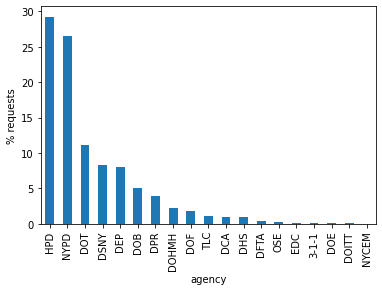

In [7]:
(df.agency.value_counts() *100 / len(df)).plot(kind='bar')

plt.ylabel('% requests')
plt.xlabel('agency')

plt.show()

#### Complaints are also concentrated in areas around a small set of zip codes such as {10040, 10467, 11226}

<AxesSubplot:xlabel='agency', ylabel='clean_zip'>

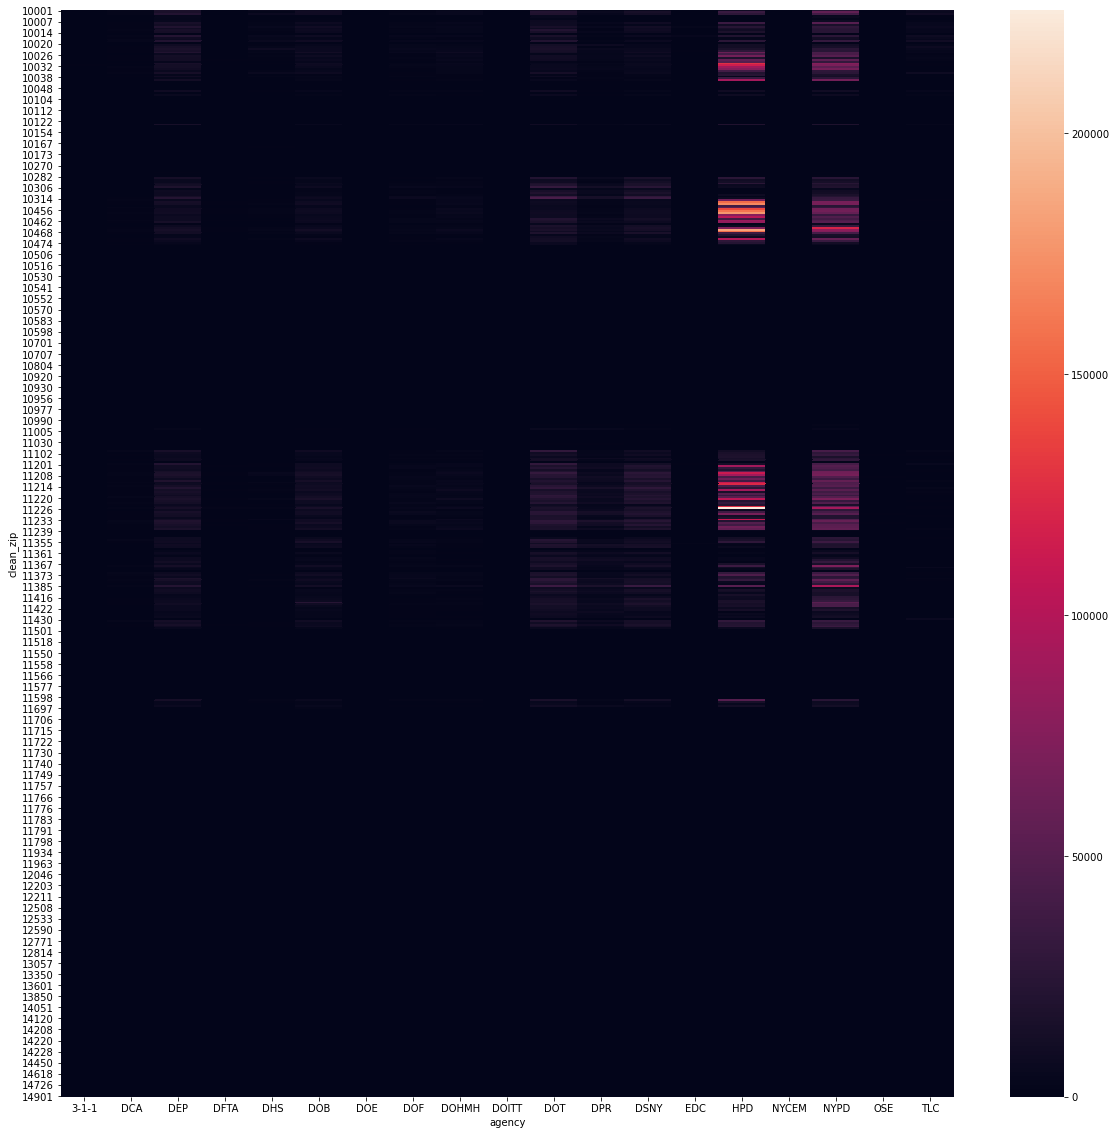

In [8]:
fix, ax = plt.subplots(figsize=(20,20))

sns.heatmap(
    pd.pivot_table(
        df,
        index='clean_zip',
        columns='agency',
        values='unique_key',
        aggfunc='nunique',
        fill_value=0
    ),
    ax=ax
)

## Q2. For each zip code, find which other zip code they are most and least similar to.  

To assess the similarity between zip codes, we compute the cosine distance between their feature vectors (cosine similarity). These feature vectors are a combination of per agency request volume and median (less suspeptible to outliers) response time, alongside volume per heuristic complaint category.

Had additional time been allocated to this work, we would have generated more sophisticated features based on aggregations of word embeddings for the textual fields not currently included (such as `resolution_description`), and would have performed feature selection to reduce sparsity

In [9]:
feature_dfs = []

for feature_calc in [
    ('agency', 'unique_key', 'nunique'),
    ('agency', 'time_to_resolution_min', 'median'),
    ('complaint_cat', 'unique_key', 'nunique')
    ]:
    
    _pvt = pd.pivot_table(
            df,
            index='clean_zip',
            columns=feature_calc[0],
            values=feature_calc[1],
            aggfunc=feature_calc[2],
            fill_value=0
        )
    _pvt.columns = [col + f'_{feature_calc[1]}_{feature_calc[2]}' for col in _pvt.columns]

    feature_dfs.append(_pvt)

In [10]:
# concatenate features
df_features_raw = pd.concat(feature_dfs, axis=1)

# check if clean_zip is the unique key
assert df.clean_zip.nunique() == len(df_features_raw)

df_features_raw.head()

,3-1-1_unique_key_nunique,DCA_unique_key_nunique,DEP_unique_key_nunique,DFTA_unique_key_nunique,DHS_unique_key_nunique,DOB_unique_key_nunique,DOE_unique_key_nunique,DOF_unique_key_nunique,DOHMH_unique_key_nunique,DOITT_unique_key_nunique,DOT_unique_key_nunique,DPR_unique_key_nunique,DSNY_unique_key_nunique,EDC_unique_key_nunique,HPD_unique_key_nunique,NYCEM_unique_key_nunique,NYPD_unique_key_nunique,OSE_unique_key_nunique,TLC_unique_key_nunique,3-1-1_time_to_resolution_min_median,DCA_time_to_resolution_min_median,DEP_time_to_resolution_min_median,DFTA_time_to_resolution_min_median,DHS_time_to_resolution_min_median,DOB_time_to_resolution_min_median,...,smoking_unique_key_nunique,snow_unique_key_nunique,special_unique_key_nunique,stalled_unique_key_nunique,street_unique_key_nunique,sustainability_unique_key_nunique,sweeping/inadequate_unique_key_nunique,sweeping/missed_unique_key_nunique,sweeping/missed-inadequate_unique_key_nunique,taxi_unique_key_nunique,taxpayer_unique_key_nunique,teaching/learning/instruction_unique_key_nunique,traffic_unique_key_nunique,traffic/illegal_unique_key_nunique,transportation_unique_key_nunique,unleashed_unique_key_nunique,unsanitary_unique_key_nunique,urinating_unique_key_nunique,utility_unique_key_nunique,vacant_unique_key_nunique,vending_unique_key_nunique,violation_unique_key_nunique,water_unique_key_nunique,weatherization_unique_key_nunique,x-ray_unique_key_nunique
clean_zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,136,3270,16381,249,5687,8302,27,1255,2890,110,10605,1356,6132,488,9441,0,24367,876,8463,0.791667,22437.716667,4305.0,5755.866667,73.516667,7181.608333,...,4,285,634,1,5834,98,0,9,4,6707,1,0,410,60,0,8,889,69,2,14,1058,135,6346,0,2
10002,219,1951,15389,601,1813,9549,233,1970,4994,141,20575,5500,13692,473,34084,0,56704,677,5351,0.650000,5362.600000,3377.0,7231.450000,51.183333,10671.516667,...,7,295,903,12,9902,49,3,36,16,3321,2,8,3439,286,2,9,3090,82,4,22,242,499,15097,1,0
10003,262,2002,20749,307,6562,9191,129,2954,4675,201,18989,3896,10654,422,26895,0,39564,917,9562,0.658333,5481.991667,4334.0,6713.150000,54.825000,8950.533333,...,2,294,750,2,8532,34,8,21,28,6348,3,4,394,86,1,15,2450,100,3,17,558,427,12332,0,0
10004,21,629,3141,21,565,837,29,314,500,58,5132,639,553,76,354,0,4843,135,1235,2.250000,22494.200000,4776.0,8245.900000,67.433333,8726.516667,...,1,30,63,0,3079,12,0,0,0,995,0,0,887,8,2,3,43,6,0,0,1029,192,480,0,0
10005,61,465,3783,12,637,857,0,519,330,44,4978,190,564,31,436,0,5845,96,1083,0.700000,22538.016667,5757.0,5279.625000,74.183333,8757.266667,...,0,17,113,0,2611,10,0,1,1,888,1,0,506,9,0,0,55,11,0,0,843,23,335,0,0


#### Scale each feature by its maximum absolute value

Each feature is scaled individually, such that the max absolute value of each feature is 1. It does not shift the data, thus does not destroy any sparsity [[1](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)].

In [11]:
df_features = df_features_raw / abs(df_features_raw.max(axis=0))

df_features.describe()

,3-1-1_unique_key_nunique,DCA_unique_key_nunique,DEP_unique_key_nunique,DFTA_unique_key_nunique,DHS_unique_key_nunique,DOB_unique_key_nunique,DOE_unique_key_nunique,DOF_unique_key_nunique,DOHMH_unique_key_nunique,DOITT_unique_key_nunique,DOT_unique_key_nunique,DPR_unique_key_nunique,DSNY_unique_key_nunique,EDC_unique_key_nunique,HPD_unique_key_nunique,NYCEM_unique_key_nunique,NYPD_unique_key_nunique,OSE_unique_key_nunique,TLC_unique_key_nunique,3-1-1_time_to_resolution_min_median,DCA_time_to_resolution_min_median,DEP_time_to_resolution_min_median,DFTA_time_to_resolution_min_median,DHS_time_to_resolution_min_median,DOB_time_to_resolution_min_median,...,smoking_unique_key_nunique,snow_unique_key_nunique,special_unique_key_nunique,stalled_unique_key_nunique,street_unique_key_nunique,sustainability_unique_key_nunique,sweeping/inadequate_unique_key_nunique,sweeping/missed_unique_key_nunique,sweeping/missed-inadequate_unique_key_nunique,taxi_unique_key_nunique,taxpayer_unique_key_nunique,teaching/learning/instruction_unique_key_nunique,traffic_unique_key_nunique,traffic/illegal_unique_key_nunique,transportation_unique_key_nunique,unleashed_unique_key_nunique,unsanitary_unique_key_nunique,urinating_unique_key_nunique,utility_unique_key_nunique,vacant_unique_key_nunique,vending_unique_key_nunique,violation_unique_key_nunique,water_unique_key_nunique,weatherization_unique_key_nunique,x-ray_unique_key_nunique
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,...,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,0.038833,0.098995,0.134475,0.079470,0.040721,0.079420,0.074731,0.098098,0.091050,0.039232,0.092461,0.082432,0.087262,0.010288,0.047001,0.012168,0.079778,0.100664,0.039153,0.062079,0.032407,0.082190,0.016930,0.006296,0.015883,...,0.059211,0.070619,0.032128,0.022479,0.079471,0.055503,0.030006,0.037764,0.041802,0.034495,0.053249,0.047016,0.072074,0.065472,0.036672,0.076905,0.048311,0.047303,0.071081,0.037703,0.033476,0.030570,0.064115,0.046859,0.004663
std,0.090231,0.192011,0.238763,0.165936,0.107117,0.146035,0.155242,0.183639,0.174855,0.106297,0.169966,0.163142,0.171149,0.059759,0.125933,0.075249,0.155995,0.201007,0.122026,0.124686,0.053596,0.135315,0.046247,0.043511,0.051006,...,0.153686,0.145118,0.083749,0.069026,0.148189,0.129322,0.088960,0.108170,0.120478,0.114421,0.128943,0.123676,0.157285,0.133046,0.121833,0.155955,0.122587,0.104664,0.155375,0.106049,0.102532,0.079145,0.148003,0.132073,0.042797
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008859,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.001765,0.000000,0.000566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000499,0.000000,

<AxesSubplot:ylabel='clean_zip'>

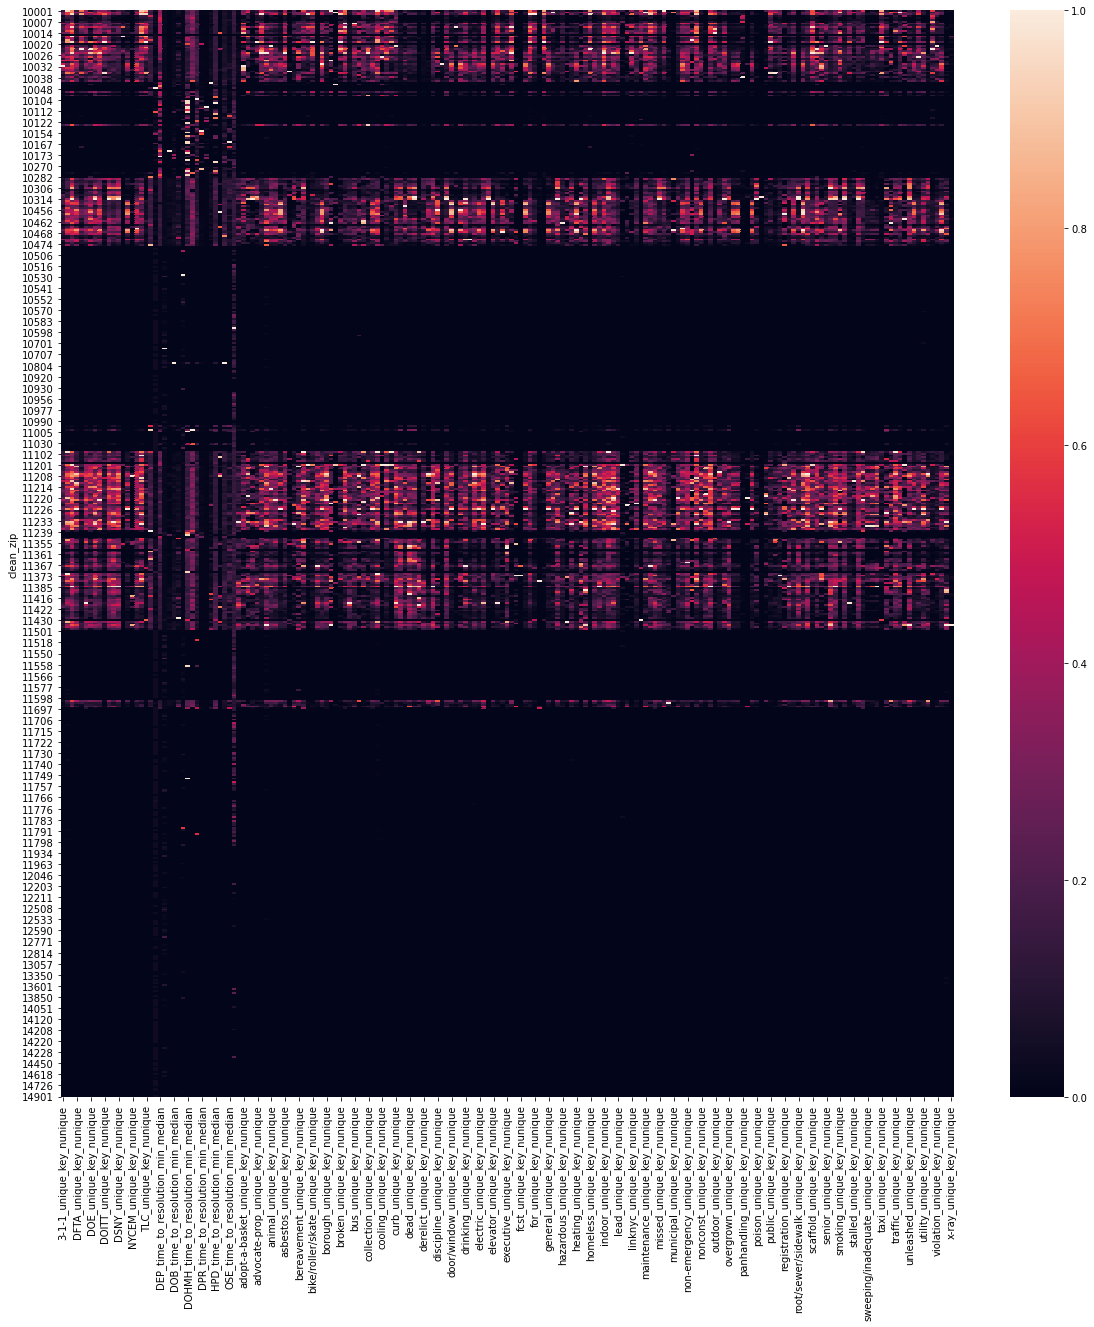

In [12]:
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(df_features, ax=ax)

#### Compute the most and least similar ZIP codes based on cosine similarity 

<AxesSubplot:>

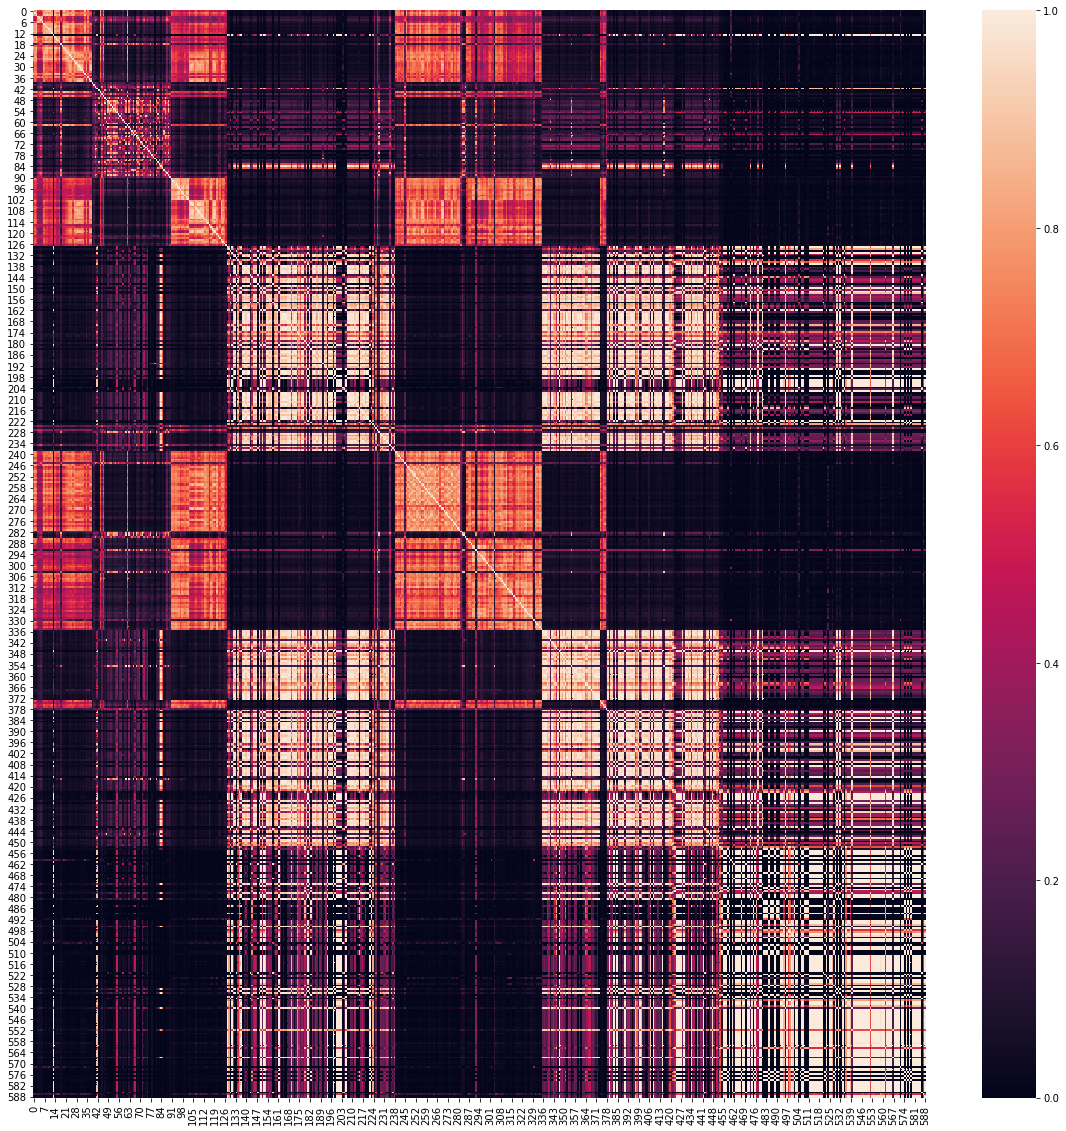

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cosine_similarity(df_features), ax=ax)

In [14]:
similarities = cosine_similarity(df_features)

similarities[:5]

array([[1.        , 0.75685192, 0.86262423, ..., 0.0046969 , 0.2638015 ,
        0.01543026],
       [0.75685192, 1.        , 0.82952842, ..., 0.00522241, 0.13554717,
        0.00509015],
       [0.86262423, 0.82952842, 1.        , ..., 0.00612104, 0.13625881,
        0.00510959],
       [0.58198861, 0.49176122, 0.54217981, ..., 0.01016241, 0.16616584,
        0.03209059],
       [0.5799784 , 0.45085792, 0.55422383, ..., 0.01152256, 0.142467  ,
        0.035073  ]])

In [15]:
top_bottom_zips = []
k = 10

for row in similarities:
    idx = np.argsort(row).reshape(-1,)
    
    top_k = idx[-k-1:][::-1].tolist()
    bottom_k = idx[:k].tolist()
    
    top_bottom_zips.append(df_features.index[top_k + bottom_k].tolist()) # not including self
    
    
# construct dataframe with the k most and least similar ZIP codes for each ZIP code
df_zip_similarity = pd.DataFrame.from_records(
    top_bottom_zips, 
    columns=['zip']+[f'top_{i + 1}' for i in range(k)]+[f'bottom_{i + 1}' for i in range(k)]
).set_index('zip')

df_zip_similarity.head()

,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,bottom_1,bottom_2,bottom_3,bottom_4,bottom_5,bottom_6,bottom_7,bottom_8,bottom_9,bottom_10
zip,,,,,,,,,,,,,,,,,,,,
10001,10022,10017,10013,10003,10036,10010,10016,10018,10011,10019,13480,10560,13903,10537,13329,12122,14883,12721,11946,14616
10002,11211,10003,10009,10013,10027,11201,11217,10011,11206,10025,10560,13903,14845,12540,14094,11705,11764,12787,10505,13756
10003,10011,10019,10016,10022,10010,10036,10028,10013,10012,10009,13480,10560,13903,14845,12540,14094,11705,11764,12787,10505
10004,10007,10005,10006,10038,10017,10018,10036,10010,10019,10022,13480,10560,13903,10537,13329,12122,14883,10509,12533,10930
10005,10007,10004,10006,10038,10017,10075,10280,10036,10065,10022,13480,12533,10560,13903,10537,13329,12122,14883,10509,12865


#### Unsuprisingly, ZIP codes seem similar to ZIP codes in close geographic proximity

Note that we did not include latitude or longitude information in the feature vectors as we suspected this might be the case

In [16]:
df_zip_similarity.to_csv('results/q2_zipcode_similarity.csv')

## Q3. What are the anomalous zip codes for each agency?

To detect anomalous ZIP codes, we compare simple unsupervised learning algorithms that do not make strong assumptions about the underlying data distribution:

- [DBSCAN](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) (`dbscan`): a density-based clustering non-parametric algorithm which marks as outliers points that lie alone in low-density regions (nearest neighbours are too far)
- [Isolation Forest](https://www.google.com/search?sxsrf=ALeKk03C3a1vJSPEoOyXZgLVqU-HSn5i5g%3A1616042910521&ei=nttSYLe4H46pgAawpJugDQ&q=isolation+forest+paper&oq=isolation+forest+paper&gs_lcp=Cgdnd3Mtd2l6EAMyAggAMgYIABAWEB4yBggAEBYQHjoHCAAQsAMQQzoECAAQQzoHCAAQhwIQFFCZJFiJLGDVLGgBcAJ4AIABYIgBhgSSAQE3mAEAoAEBqgEHZ3dzLXdpesgBCsABAQ&sclient=gws-wiz&ved=0ahUKEwi3__38hLnvAhWOFMAKHTDSBtQQ4dUDCA0&uact=5) (`if`): unsupervised learning algorithm that explicitly isolates anomalous points by randomly selecting a feature and split value between the maximum and minimum values of the selected feature
- [kNN](https://www.google.com/search?q=Fabrizio+Angiulli+and+Clara+Pizzuti.+Fast+outlier+detection+in+high+dimensional+spaces.+In+European+Conference+on+Principles+of+Data+Mining+and+Knowledge+Discovery%2C+15%E2%80%9327.+Springer%2C+2002.&oq=Fabrizio+Angiulli+and+Clara+Pizzuti.+Fast+outlier+detection+in+high+dimensional+spaces.+In+European+Conference+on+Principles+of+Data+Mining+and+Knowledge+Discovery%2C+15%E2%80%9327.+Springer%2C+2002.&aqs=chrome..69i57.407j0j4&sourceid=chrome&ie=UTF-8): k-Nearest Neighbour-based algorithm that views the distance of a point to its kth nearest neighbour as an outlier score
- [OneClassSVM](https://papers.nips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf)(`ocsvm`):  SVM-based novelty detection algorithm that finds a function that is positive for regions with high density of points, and negative for small densities

Had additional time been allocated to this work, we would..:
- tune key hyperparameters e.g. kernel bandwidth parameter in `ocsvm`
- examine the outlier scores to consider the confidence of the anomaly detection algorithms
- consider the effect of feature sparsity on the performance of the anomaly detectors
- evaluate deep learning methods such as Autoencoders

#### Construct a simple set of features similarly to Q2

In [17]:
df_agency_zip = df\
.groupby(['agency', 'clean_zip'])\
.agg(num_requests=('unique_key', 'nunique'),
    resolution_time=('time_to_resolution_min', 'median'))

_pvt = pd.pivot_table(
    data=df,
    index=['agency', 'clean_zip'],
    columns='complaint_cat',
    values='unique_key',
    aggfunc='nunique',
    fill_value=0
)

df_agency_zip = df_agency_zip.join(_pvt)
df_agency_zip.head()

num_requests  resolution_time  abandoned  adopt-a-basket  \
agency clean_zip                                                             
3-1-1  10001               136         0.791667          0               0   
       10002               219         0.650000          0               0   
       10003               262         0.658333          0               0   
       10004                21         2.250000          0               0   
       10005                61         0.700000          0               0   

                  advocate  advocate-personal  advocate-prop  air  \
agency clean_zip                                                    
3-1-1  10001             0                  0              0    0   
       10002             0                  0              0    0   
       10003             0                  0              0    0   
       10004             0                  0              0    0   
       10005             0                  0              0    0   

                  alzheimer's  animal  animal-abuse  appliance  asbestos  atf  \
agency clean_zip                                                                
3-1-1  10001                0       0             0          0         0    0   
       10002                0       0             0          0         0    0   
       10003                0       0             0          0         0    0   
       10004                0       0             0          0         0    0   
       10005                0       0             0          0         0    0   

                  beach/pool/sauna  bereavement  best/site  bike  \
agency clean_zip                                                   
3-1-1  10001                     0            0          0     0   
       10002                     0            0          0     0   
       10003                     0            0          0     0   
       10004                     0            0          0     0   
       10005                     0            0          0     0   

                  bike/roller/skate  blocked  boilers  borough  bottled  \
agency clean_zip                                                          
3-1-1  10001                      0        0        0        0        0   
       10002                      0        0        0        0        0   
       10003                      0        0        0        0        0   
       10004                      0        0        0        0        0   
       10005                      0        0        0        0        0   

                  bridge  broken  ...  smoking  snow  special  stalled  \
agency clean_zip                  ...                                    
3-1-1  10001           0       0  ...        0     0        0        0   
       10002           0       0  ...        0     0        0        0   
       10003           0       0  ...        0     0        0        0   
       10004           0       0  ...        0     0        0        0   
       10005           0       0  ...        0     0        0        0   

                  street  sustainability  sweeping/inadequate  \
agency clean_zip                                                
3-1-1  10001           0               0                    0   
       10002           0               0                    0   
       10003           0               0                    0   
       10004           0               0                    0   
       10005           0               0                    0   

                  sweeping/missed  sweeping/missed-inadequate  taxi  taxpayer  \
agency clean_zip                                                                
3-1-1  10001                    0                           0     0         0   
       10002                    0                           0     0         0   
       10003                    0                           0     0         0   
       10004                    0   

#### Visualising two of the key features (`num_requests`, `resolution_time`) for the top 5 agencies shows potential outliers

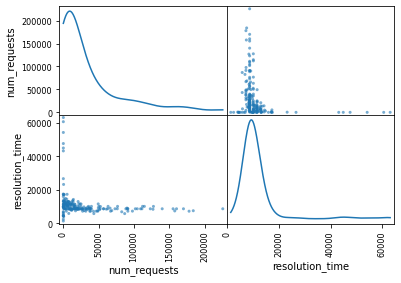

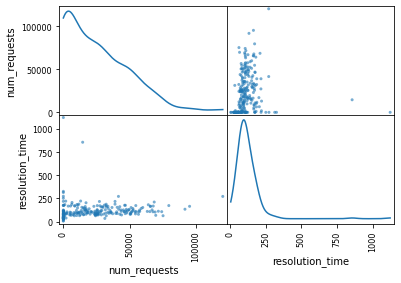

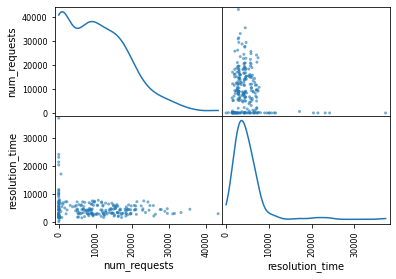

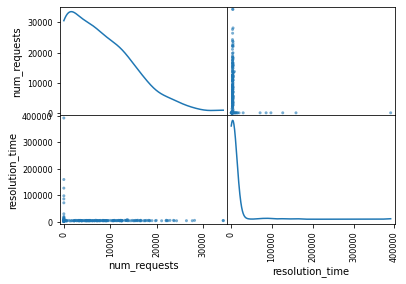

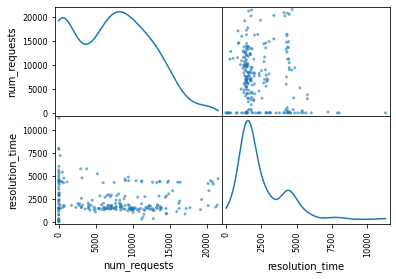

In [18]:
top_agencies = df.agency.value_counts()[:5].index.tolist()

for top_agency in top_agencies:
    df_plot = df_agency_zip.loc[top_agency][['num_requests', 'resolution_time']]
    pd.plotting.scatter_matrix(df_plot, alpha=0.6, diagonal='kde')

#### There are enough ZIP codes per agency for an indicative anomaly detection analysis

array([[<AxesSubplot:title={'center':'total_zips_per_agency'}>]],
      dtype=object)

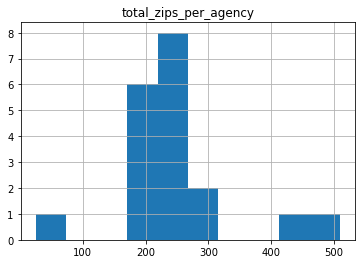

In [19]:
zips_per_agency = df.groupby(['agency']).agg(total_zips_per_agency=('clean_zip', 'nunique'))

zips_per_agency.hist()

#### We normalise our features using absolute max scaling to maintain sparsity

In [20]:
for col in df_agency_zip.columns:
    df_agency_zip[col] = df_agency_zip.groupby('agency')[col].transform(lambda x: x/x.max())
df_agency_zip.fillna(0, inplace=True)

In [21]:
df_agency_zip.describe()

,num_requests,resolution_time,abandoned,adopt-a-basket,advocate,advocate-personal,advocate-prop,air,alzheimer's,animal,animal-abuse,appliance,asbestos,atf,beach/pool/sauna,bereavement,best/site,bike,bike/roller/skate,blocked,boilers,borough,bottled,bridge,broken,...,smoking,snow,special,stalled,street,sustainability,sweeping/inadequate,sweeping/missed,sweeping/missed-inadequate,taxi,taxpayer,teaching/learning/instruction,traffic,traffic/illegal,transportation,unleashed,unsanitary,urinating,utility,vacant,vending,violation,water,weatherization,x-ray
count,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,...,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.00000,4510.000000
mean,0.173204,0.100657,0.005003,0.008130,0.007268,0.005155,0.006036,0.008437,0.011626,0.020683,0.008819,0.006165,0.018312,0.001547,0.004451,0.007095,0.010038,0.004035,0.005538,0.006587,0.010691,0.007822,0.007007,0.001430,0.006115,...,0.007733,0.009223,0.004196,0.002936,0.010379,0.007249,0.003919,0.004932,0.005459,0.004505,0.006954,0.006140,0.012847,0.008551,0.004789,0.010044,0.017668,0.006178,0.009283,0.005256,0.004372,0.003992,0.026661,0.00612,0.000609
std,0.208644,0.134404,0.037187,0.056188,0.054623,0.040962,0.044575,0.056768,0.071692,0.086165,0.052684,0.050125,0.079078,0.022279,0.036117,0.049751,0.064522,0.039010,0.043236,0.047155,0.069346,0.052825,0.058096,0.029289,0.050655,...,0.058977,0.057555,0.032123,0.026052,0.059841,0.050307,0.033679,0.041083,0.045731,0.042924,0.049902,0.047389,0.070724,0.052869,0.045699,0.061995,0.083250,0.041020,0.061008,0.043609,0.038707,0.030381,0.102602,0.05024,0.015534
min,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.002415,0.018635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.092900,0.047082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.285115,0.137590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

#### utility plot function for visualising the count and percentage of outliers detected by an anomaly detector

In [22]:
def plot_outliers_stats(method: str, stats: Dict[str, List[Union[int, float]]], xlabels: List[str], sort: bool=False):
    """
    Plots the number of outliers detected per agency (left axis) and
    the % of outliers out of the total number of zip codes (right axis).
    """
    
    x = np.arange(len(agencies))
    
    if sort:
        totals, percs, xlabels = zip(*sorted(zip(stats['total_anoms'], 
                                                  stats['perc_anoms'], 
                                                  xlabels), reverse=True))
    else:
        totals = stats['total_anoms']
        percs = stats['perc_anoms']

    fig = plt.figure()
    
    ax1=fig.add_subplot(111)
    ax1.set_ylabel('# outliers')
    plt.xticks(x + 0.1, xlabels, rotation='vertical')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('% outliers')
    ax2.set_ylim(0, 50)
    
    totals_ax = ax1.bar(x, totals, width=0.3, color='b', align='center')
    ps_ax = ax2.bar(x + 0.3, percs, width=0.3, color='g', align='center')
    
    plt.legend([totals_ax, ps_ax],['# outliers', '% outliers'], loc=9)
    plt.title(f'{method}')
    
    plt.show()

In [23]:
class AnomalyDetector:
    def __init__(self, method: str, seed: int=0):
        self.method = method
        
        if method == 'dbscan':
            self.model = DBSCAN(eps=0.7, min_samples=10)
            # returns -1 for outliers and 1 for inliers
            self.outlier_label = -1
        elif method == 'if':
            self.model = IsolationForest(random_state=seed, contamination='auto')
            self.outlier_label = -1
        elif method == 'knn':
            # uses the median of the distance to k neighbors as the outlier score
            self.model = KNN(method='median')
            self.outlier_label = 1
        elif method == 'ocsvm':
            self.model = OneClassSVM(kernel='rbf', nu=0.1, gamma=1e-2) 
            self.outlier_label = -1
        else:
            raise NotImplementedError(f'invalid outlier detection method: {method}')
        
    def fit_predict(self, X: pd.DataFrame):
        y = self.model.fit_predict(X)
        return y == self.outlier_label

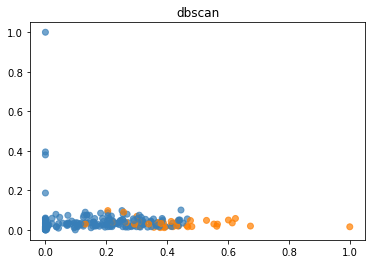

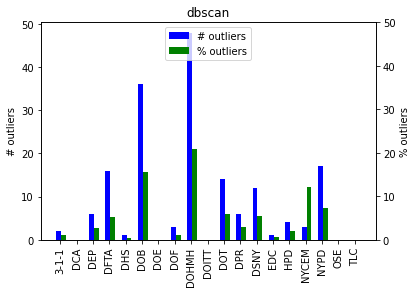

time: 0.33


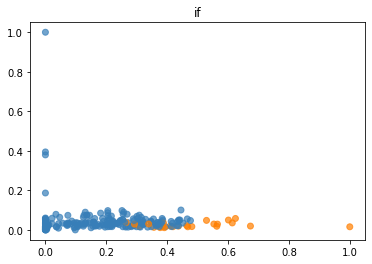

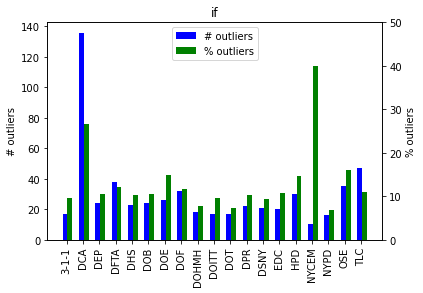

time: 2.18


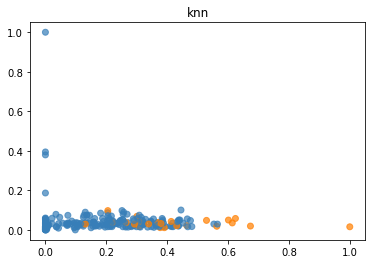

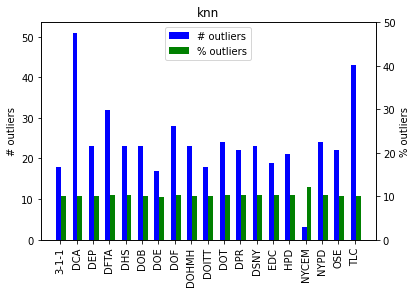

time: 0.31


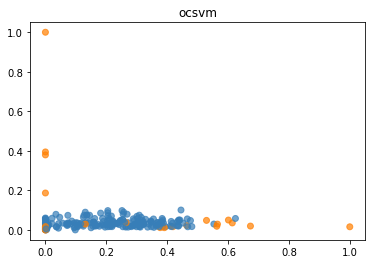

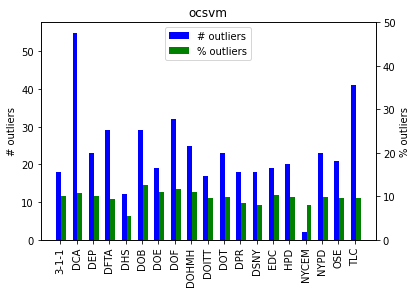

time: 0.44


In [24]:
agencies = df_agency_zip.index.unique(level='agency').tolist()
stats = {}

methods = ['dbscan', 'if', 'knn', 'ocsvm']
times = []

for method in methods:
    start_time = time.time()
    
    df_agency_zip[f'is_outlier_{method}'] = False
    per_agency_stats = defaultdict(list)

    for i, agency in enumerate(agencies):
        X = df_agency_zip.loc[agency]

        detector = AnomalyDetector(method=method)
        
        y = detector.fit_predict(X)
        df_agency_zip.loc[agency, f'is_outlier_{method}'] = y
        
        # visualise anomalies using two likely influential features
        if i == 5:
            colors = np.array(['#377eb8', '#ff7f00']) 
            plt.scatter(X['num_requests'], X['resolution_time'], alpha=0.7, c=colors[(y + 1) // 2])
            plt.title(f'{method}')
            plt.show()
        
        # store count and % of anomalous zip codes
        num_anom = sum(y)
        perc_anom = round(num_anom * 100/len(y), 2)

        per_agency_stats['total_anoms'].append(num_anom)
        per_agency_stats['perc_anoms'].append(perc_anom)
    
    # plot stats
    plot_outliers_stats(method=method, stats=per_agency_stats, xlabels=agencies)
    
    stats[method] = per_agency_stats
    
    print(f'time: {time.time() - start_time:.2f}')

Although we do not exhaustively evaluate the algorithms, we choose OCSVM because:
- its performance could be potentially improved by optimising the kernel parameters
- it can scale to larger datasets
- it is robust to noisy samples
- ..

#### Prepare dataframe for exporting

In [25]:
df_agency_zip.reset_index(inplace=True)

df_agency_anom_zips = df_agency_zip[df_agency_zip['is_outlier_ocsvm'] == True][['agency', 'clean_zip']]

df_agency_anom_zips.head()

,agency,clean_zip
20,3-1-1,10024
22,3-1-1,10026
28,3-1-1,10032
42,3-1-1,10280
67,3-1-1,10462


In [26]:
df_agency_anom_zips.to_csv('results/q3_anomalous_zips_per_agency.csv', index=False)